# **House Price Prediction**
***Charles Zhang*** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Jan 19 2020**

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor

# 1. Process Data

In [8]:
test_df = pd.read_csv("https://raw.githubusercontent.com/zcczhang/House_Price_Prediction_Model/master/input/test.csv", index_col=0)
train_df = pd.read_csv("https://raw.githubusercontent.com/zcczhang/House_Price_Prediction_Model/master/input/train.csv", index_col=0)
train = pd.read_csv("https://raw.githubusercontent.com/zcczhang/House_Price_Prediction_Model/master/input/train.csv", index_col=0)

In [9]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
#shape of train data
train_df.shape

(1460, 80)

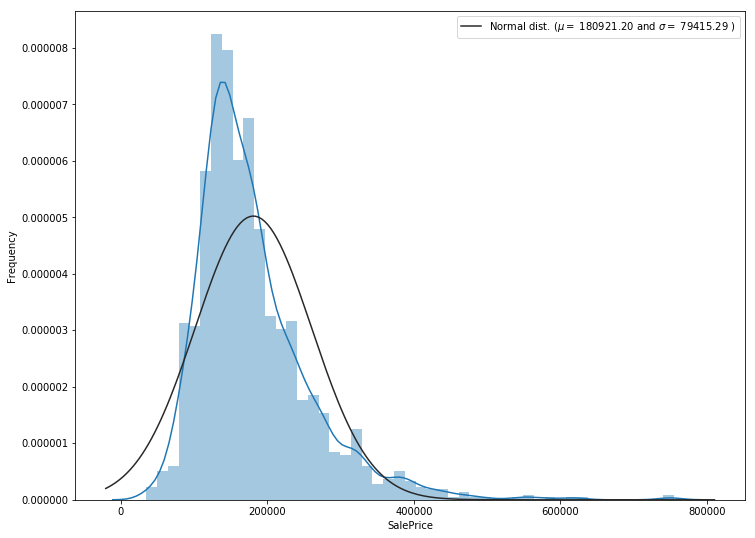

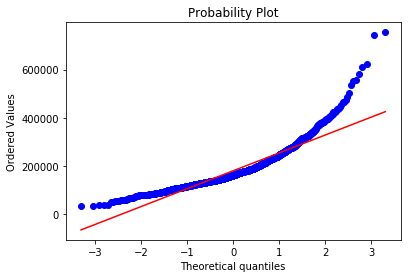

In [11]:
plt.subplots(figsize=(12,9))
sns.distplot(train['SalePrice'], fit=stats.norm)

# Get the fitted parameters used by the function

(mu, sigma) = stats.norm.fit(train['SalePrice'])

# plot with the distribution

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')

#Probablity plot

fig = plt.figure()
stats.probplot(train['SalePrice'], plot=plt)
plt.show()

> This target varibale is right skewed. Now, we need to tranform this variable and make it normal distribution.

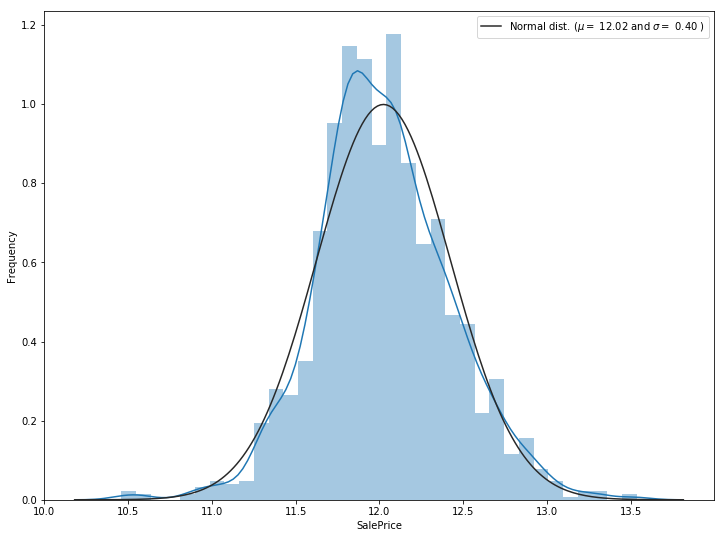

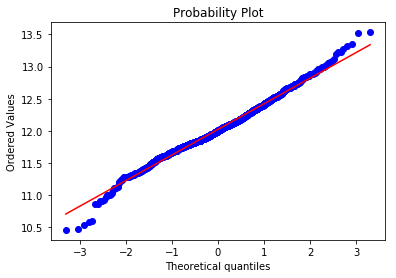

In [12]:
#we use log function which is in numpy
train['SalePrice'] = np.log1p(train['SalePrice'])

#Check again for more normal distribution

plt.subplots(figsize=(12,9))
sns.distplot(train['SalePrice'], fit=stats.norm)

# Get the fitted parameters used by the function

(mu, sigma) = stats.norm.fit(train['SalePrice'])

# plot with the distribution

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')

#Probablity plot

fig = plt.figure()
stats.probplot(train['SalePrice'], plot=plt)
plt.show()

> Simple Version

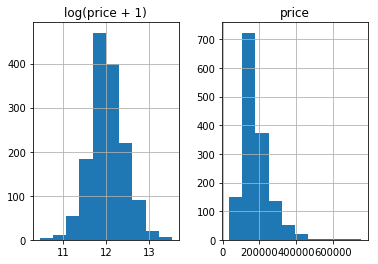

In [13]:
prices = pd.DataFrame({"price":train_df["SalePrice"], "log(price + 1)":np.log1p(train_df["SalePrice"])})
prices.hist()
y_train = np.log1p(train_df.pop('SalePrice'))

# 2. Transform Variables

In [14]:
# connect
all_df = pd.concat((train_df, test_df), axis=0)
all_df.shape

(2919, 79)

> change variables attributes

In [15]:
all_df['MSSubClass'].dtypes

dtype('int64')

In [16]:
all_df['MSSubClass'] = all_df['MSSubClass'].astype(str)
all_dummy_df = pd.get_dummies(all_df)
all_dummy_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


> use get_dummies method to use One-Hot method to represent the categories, dividing into 12 classes, true=1 while false=0

#### Check the Missing Value

In [17]:
all_dummy_df.isnull().sum().sort_values(ascending=False).head(10)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
BsmtFinSF2        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
GarageArea        1
dtype: int64

In [18]:
# use means to fill
mean_cols = all_dummy_df.mean()
all_dummy_df = all_dummy_df.fillna(mean_cols)

### normalization

In [19]:
numeric_cols = all_df.columns[all_df.dtypes != 'object']
numeric_col_means = all_dummy_df.loc[:, numeric_cols].mean()
numeric_col_std = all_dummy_df.loc[:, numeric_cols].std()
# Standard distribution (X-X')/s(or use log)
all_dummy_df.loc[:, numeric_cols] = (all_dummy_df.loc[:, numeric_cols] - numeric_col_means) / numeric_col_std

In [20]:
all_dummy_df.isnull().sum().sum()

0

# 3. Build Models

In [21]:
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]
dummy_train_df.shape, dummy_test_df.shape

((1460, 303), (1459, 303))

- ### Ridge Regression

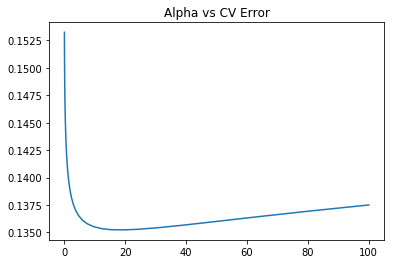

In [22]:
X_train = dummy_train_df.values
X_test = dummy_test_df.values

alphas = np.logspace(-3, 2, 50)
test_scores = []
for alpha in alphas:
    clf = Ridge(alpha)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
# choose and see the best alpha

plt.plot(alphas, test_scores)
plt.title("Alpha vs CV Error");

> when alpha = 10-20, teh score could be around 0.135

- ### Random Forest

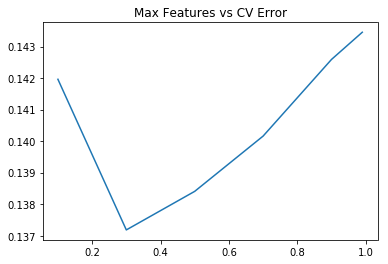

In [23]:
max_features = [.1, .3, .5, .7, .9, .99]
test_scores = []
for max_feat in max_features:
    clf = RandomForestRegressor(n_estimators=200, max_features=max_feat)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
plt.plot(max_features, test_scores)
plt.title("Max Features vs CV Error");

> use alpha = 18 as the best parameter to ensemble

In [24]:
ridge = Ridge(15.5)

- ### Bagging

In [25]:
params = [1, 10, 15, 20, 25, 30, 40]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param, base_estimator=ridge)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

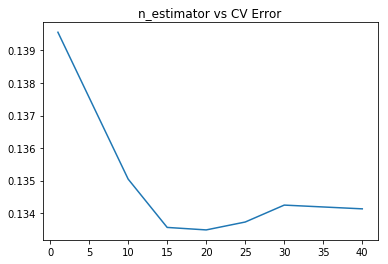

In [26]:
plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error");

> around 0.133

- ### Boosting

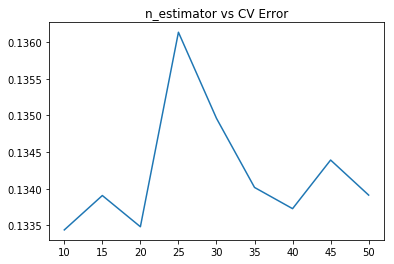

In [ ]:
params = [10, 15, 20, 25, 30, 35, 40, 45, 50]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param, base_estimator=ridge)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error");

> Adaboost+Ridge

In [ ]:
params = [10, 15, 20, 25, 30, 35, 40, 45, 50]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error");

> with default DT

- ### XGboost

In [ ]:
params = [1,2,3,4,5,6]
test_scores = []
for param in params:
    clf = XGBRegressor(max_depth=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

In [ ]:
plt.plot(params, test_scores)
plt.title("max_depth vs CV Error");

> score is around 0.127, which is the best for now

In [ ]:
xg = XGBRegressor(n_estimators=500, max_features=.3)

In [ ]:
ridge.fit(X_train, y_train)
xg.fit(X_train, y_train)

In [ ]:
y_ridge = np.expm1(ridge.predict(X_test))
y_xg = np.expm1(xg.predict(X_test))

In [ ]:
y_final = (y_ridge + y_xg) / 2

In [ ]:
submission_df = pd.DataFrame(data= {'Id' : test_df.index, 'SalePrice': y_final})

In [ ]:
submission_df.head(10)